In [32]:
from pathlib import Path
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np


BASE = Path.cwd().parent.parent / 'WikiData.nosync'


## Distribution of PIDs per QID

This block loads the SQLite database, counts how many property IDs (PIDs) are associated with each QID and plots the distribution. PIDs counts are grouped in pairs (1–2, 3–4, etc.).

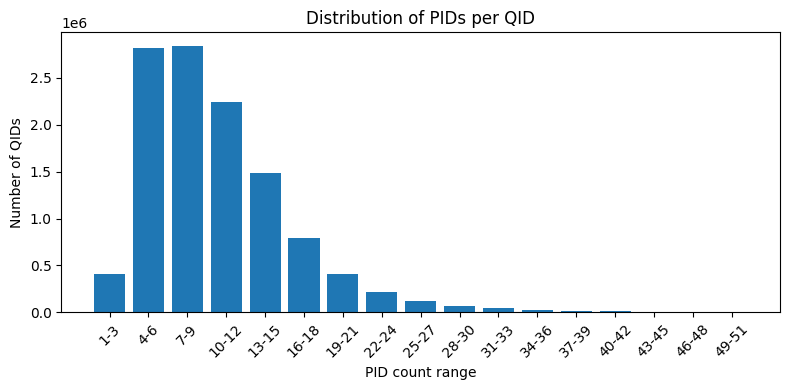

In [30]:
DB_PATH = BASE / 'wikidata_labeled_-missing.db'

# Connect to the SQLite DB and read into pandas
# ←── adjustable parameters ──→
bucket_size = 3     # group every N counts together
x_min, x_max = 1, 50  # only show buckets starting from x_min up to x_max
# ←───────────────────────────→

# 1) load from SQLite
conn = sqlite3.connect(str(DB_PATH))
query = """
    SELECT qid, COUNT(pid) AS pid_count
      FROM properties_labeled
     GROUP BY qid
"""
df = pd.read_sql_query(query, conn)
conn.close()

# 2) assign each qid to a bucket
#    e.g. pid_count=1,2,3 → bucket=1; 4,5,6 → bucket=4; etc.
df['bucket'] = ((df['pid_count'] - 1) // bucket_size) * bucket_size + 1

# 3) count per bucket and sort
bucket_counts = df['bucket'].value_counts().sort_index()

# 4) optionally filter to a sub‐range of buckets
mask = (bucket_counts.index >= x_min) & (bucket_counts.index <= x_max)
bucket_counts = bucket_counts.loc[mask]

# 5) plot
plt.figure(figsize=(8,4))
labels = [f"{b}-{b + bucket_size - 1}" for b in bucket_counts.index]
plt.bar(labels, bucket_counts.values)
plt.xlabel('PID count range')
plt.ylabel('Number of QIDs')
plt.title('Distribution of PIDs per QID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Statistics of Death Dates

This block reads `death_dates_clean.json` and calculates the median and mean of the death dates.

In [31]:
DEATH_PATH = BASE / 'death_dates_clean.json'
with open(DEATH_PATH, 'r', encoding='utf-8') as f:
    death_data = json.load(f)

# Convert to a pandas Series (so .median()/.mean() are available)
dates = pd.Series(
    pd.to_datetime(
        list(death_data.values()),
        errors='coerce'
    )
).dropna()

median_date = dates.median()
mean_date   = dates.mean()

print(f"Median death date: {median_date.date()}")
print(f"Mean death date:   {mean_date.date()}")

Median death date: 1953-05-01
Mean death date:   1938-05-28
